In [44]:
from __future__ import unicode_literals, print_function, division
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from cn_cn_data import get_cn_en_dataloader, to_sentence, cn_vocab, en_vocab


In [45]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [46]:
seq_len = 15
max_length = seq_len + 2
batch_size = 1

cn_vocab_size = len(cn_vocab)
en_vocab_size = len(en_vocab)

device = torch.device("cpu")
train_loader, train_dataset = get_cn_en_dataloader(seq_len, batch_size, device)
print('length of train_loader', len(train_loader))

length of train_loader 2207


In [47]:
for i, item in enumerate(train_loader):
    print(item[0].shape, item[1].shape)

    print([idx.item() for idx in item[0]])
    print(to_sentence(item[0], True))
    print([idx.item() for idx in item[1]])
    print(to_sentence(item[1], False))
    break

torch.Size([10, 1]) torch.Size([10, 1])
[2, 19, 379, 1672, 1155, 960, 323, 324, 5, 3]
['<sos>', '我', '习', '惯', '整', '夜', '工', '作', ' 。', '<eos>']
[2, 12, 27, 2229, 516, 557, 529, 260, 5, 3]
['<sos>', 'I', "'m", 'used', 'to', 'working', 'all', 'night', '.', '<eos>']


In [48]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        batch_size = inputs.size(1)
        hidden = torch.zeros(1, batch_size, self.hidden_size, device=device)
        embedded = self.dropout(self.embedding(inputs))
        outputs, hidden = self.gru(embedded, hidden)

        return outputs, hidden


In [49]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output[0])
        return output, hidden

In [50]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    target_length = target_tensor.size(0)

    loss = 0

    # encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # for ei in range(input_length):
    #     encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    #     encoder_outputs[ei] = encoder_output[0][0]

    _, encoder_hidden = encoder(input_tensor)

    decoder_input = torch.tensor([[cn_vocab['<sos>']]], device=device)

    decoder_hidden = encoder_hidden #

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            target = target_tensor[di]
            loss += criterion(decoder_output, target)
            decoder_input = target  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            target = target_tensor[di]
            loss += criterion(decoder_output, target)
            if decoder_input.item() == en_vocab['<eos>']:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [51]:
def trainIters(encoder, decoder, train_loader, print_every=100, plot_every=10, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss(ignore_index=cn_vocab['<pad>'])
    n_iters = len(train_loader)

    for iter, data in enumerate(train_loader, 1):
        input_tensor, target_tensor = data

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [52]:
hidden_size = 256
encoder1 = Encoder(cn_vocab_size, hidden_size).to(device)
decoder1 = Decoder(hidden_size, en_vocab_size).to(device)

In [53]:
train_losses = []
for i in range(10):
    print('--------------epoch %d--------------' % (i + 1))
    losses = trainIters(encoder1, decoder1, train_loader, print_every=200)
    train_losses = train_losses + losses

--------------epoch 1--------------
0m 14s (- 2m 22s) (200 9%) 3.9732
0m 29s (- 2m 11s) (400 18%) 3.3943
0m 42s (- 1m 55s) (600 27%) 3.2990
0m 56s (- 1m 39s) (800 36%) 3.2056
1m 9s (- 1m 23s) (1000 45%) 3.2668
1m 22s (- 1m 9s) (1200 54%) 3.1934
1m 36s (- 0m 55s) (1400 63%) 3.1724
1m 50s (- 0m 42s) (1600 72%) 2.9769
2m 6s (- 0m 28s) (1800 81%) 3.0708
2m 21s (- 0m 14s) (2000 90%) 3.0666
2m 38s (- 0m 0s) (2200 99%) 3.1829
--------------epoch 2--------------
0m 16s (- 2m 42s) (200 9%) 2.9347
0m 32s (- 2m 26s) (400 18%) 2.9988
0m 47s (- 2m 6s) (600 27%) 2.7989
1m 1s (- 1m 48s) (800 36%) 3.0050
1m 17s (- 1m 33s) (1000 45%) 2.8649
1m 33s (- 1m 18s) (1200 54%) 2.8997
1m 50s (- 1m 3s) (1400 63%) 2.8445
2m 7s (- 0m 48s) (1600 72%) 2.8198
2m 24s (- 0m 32s) (1800 81%) 2.8018
2m 42s (- 0m 16s) (2000 90%) 2.7935
2m 59s (- 0m 0s) (2200 99%) 2.7641
--------------epoch 3--------------
0m 15s (- 2m 33s) (200 9%) 2.6300
0m 31s (- 2m 22s) (400 18%) 2.5715
0m 47s (- 2m 7s) (600 27%) 2.6154
1m 4s (- 1m 53s)

<Figure size 432x288 with 0 Axes>

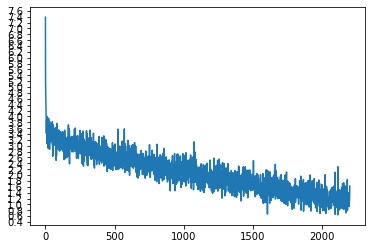

In [54]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


showPlot(train_losses)


In [55]:
encoder_path = './models/seq2seq6-encoder.pt'
decoder_path = './models/seq2seq6-decoder.pt'


In [56]:
torch.save(encoder1.state_dict(), encoder_path)
torch.save(decoder1.state_dict(), decoder_path)


In [57]:
def evaluate(encoder, decoder, sentence, max_length=max_length):
    with torch.no_grad():
        input_tensor = train_dataset.tokenize_sentence(sentence, True).unsqueeze(0).T
        input_length = input_tensor.size(0)

        _, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.tensor([cn_vocab['<sos>']], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, input_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            # decoder_attentions[di] = decoder_attention.squeeze().data
            if topi.item() == en_vocab['<eos>']:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(en_vocab.lookup_token(topi.item()))

            decoder_input = topi.squeeze(1).detach()

        return decoded_words


In [58]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_dataset.pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


In [59]:
encoder2 = Encoder(cn_vocab_size, hidden_size).to(device)
decoder2 = Decoder(hidden_size, en_vocab_size).to(device)

encoder2.load_state_dict(torch.load(encoder_path))
decoder2.load_state_dict(torch.load(decoder_path))


<All keys matched successfully>

In [60]:
evaluateRandomly(encoder1, decoder1)


> 他现在卧床不起。
= He is confined to bed now.
< <sos> He is n't to to now . <EOS>

> 他有可能赢得比赛。
= He is likely to win the game.
< <sos> He is likely to to the . <EOS>

> 我对人造语言不是很感兴趣。
= I'm not very interested in artificial languages.
< <sos> I 'm not interested in interested in history . <EOS>

> 你才是自己命运的主人。
= You're the master of your own destiny.
< <sos> You 're the only one the can . <EOS>

> 他正在画一幅画。
= He is drawing a picture.
< <sos> He is making a diet . <EOS>

> 我不太擅长运动。
= I'm not very athletic.
< <sos> I 'm not at the . . <EOS>

> 你累了，不是吗？
= You're tired, aren't you?
< <sos> You 're not brave , are n't you ? <EOS>

> 她很可爱。
= She is very pretty.
< <sos> She is very pretty . <EOS>

> 服了你了。
= You're the boss.
< <sos> I 'm counting to you . <EOS>

> 你是我的英雄。
= You're my hero.
< <sos> You 're my . <EOS>



In [61]:
output_words = evaluate(encoder1, decoder1, "我不确定。")
output_sentence = ' '.join(output_words)
print(output_sentence)


<sos> I 'm not sure of it . <EOS>


In [62]:
# def showAttention(input_sentence, output_words, attentions):
#     # Set up figure with colorbar
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attentions.numpy(), cmap='bone')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels([''] + list(input_sentence) +
#                        ['<EOS>'], rotation=90)
#     ax.set_yticklabels([''] + output_words)

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()


# def evaluateAndShowAttention(input_sentence):
#     output_words, attentions = evaluate(encoder2, decoder2, input_sentence)
#     print('input =', input_sentence)
#     print('output =', ' '.join(output_words))
#     showAttention(input_sentence, output_words, attentions)


# evaluateAndShowAttention("我不确定。")


In [63]:
cn_vocab.get_stoi()['.']

312